# Task 2: Implement Linear Classification with Crossentropy Loss 
# CENG501 - Spring 2023 - PA1

In this task, you will implement a linear classification model with cross-entropy loss. 

*Disclaimer: Many components in this notebook are adapted or taken from [CS231n](https://cs231n.github.io/) materials.*

## 1 Import the Modules

Let us start with importing some libraries that we will use throughout the task.

In [1]:
import matplotlib.pyplot as plt # For plotting
import numpy as np              # NumPy, for working with arrays/tensors 
import os                       # Built-in library for filesystem access etc.
import pickle                   # For (re)storing Python objects into (from) files 
import time                     # For measuring time

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

## 2 The Dataset

Like Task 1, we will use the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. In this task, we will directly load and continue with preprocessing steps. Please see Task 1 for more details about the dataset. 

### 2.1 Download the Dataset


In [2]:
# Download the file
! wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

# Extract the compressed file
! tar zxvf cifar-10-python.tar.gz

--2023-04-20 18:21:29--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  98.7MB/s    in 1.6s    

2023-04-20 18:21:30 (98.7 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


### 2.2 Load the Dataset

*Disclaimer: This loader is adapted from [CS231n](https://cs231n.github.io/) materials.*

In [3]:
def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = pickle.load(f, encoding='latin1')
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

def get_CIFAR10_data(cifar10_dir, num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for classifiers. These are the same steps as we used for the SVM, but
    condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

# Now use these functions to load the dataset:
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data('cifar-10-batches-py/')

X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# Note that 32x32x3 = 3072
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (49000, 3072)
Training labels shape:  (49000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


### 2.3 Preprocessing

We will perform two preprocessing steps: Subtracting the mean and adding a bias dimension to the inputs to make things easier for calculations on the weight matrix.

*Disclaimer: This step is taken from [CS231n](https://cs231n.github.io/) materials.*

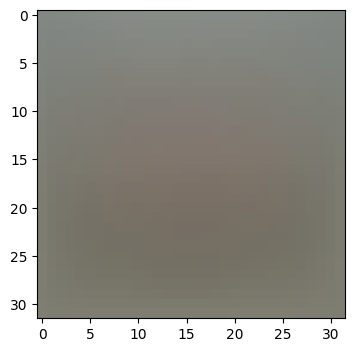

In [4]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_test -= mean_image
X_val -= mean_image

In [5]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)

Training data shape:  (49000, 3073)
Validation data shape:  (1000, 3073)
Test data shape:  (1000, 3073)


## 3 Construct the Model

In this task, we are defining a model for classification like we did in Task 1. Our model is going to be slightly different this time: Instead of raw scores, our model will output probabilities obtained using a softmax function.

### 3.1 A Model with Probability Outputs

In Task 1 and in the lectures, we covered a linear classification model, which performs a simple transformation on input $\mathbf{x}\in R^D$ using parameters $W \in R^{C\times D}$, where $D$ is the dimensionality of the input and $C$ is the number of classes. This transformation can be formally denoted as (note that $\mathbf{x}$ contains a constant 1 for the bias):
$$
\mathbf{s} = W\cdot \mathbf{x}. 
$$

If we look at this operation for class $c$, we see that this is simply a dot product:
$$
s_c = \mathbf{w}_c \cdot \mathbf{x} = \sum_{i=1}^D {w}_{ci} x_i. 
$$

We called these $s$ values scores. We can map these scores to probabilities using the softmax function $sm()$:
$$
p_c = sm(s_c) = \frac{\exp(s_c)}{\sum_j \exp(s_j)}.
$$

For numerical stability, subtract the maximum score ($s_{max} = \max(\mathbf{s})$):
$$
p_c = sm(s_c) = \frac{\exp(s_c-s_{max})}{\sum_j \exp(s_j-s_{max})}.
$$


Let us first implement this model below. In the following cell, complete the "@TODO" part of the `forward()` function. You can directly copy the `update()` and `predict()` functions from Task 1.


In [6]:
class SoftmaxLayer:

  def __init__(self, D, C):
    """
      Initialize the softmax layer. Weights are randomly initialized in a small range.

      D: The dimensionality of a single instance. 
      C: The number of classes.
    """
    self.D = D
    self.C = C
    np.random.seed(501) # for reproducibility, set the seed to a constant
    self.W = 0.001 * np.random.randn(D, C)

  def forward(self, X, W=None):
    """
    Use the current weights to obtain the probabilities for a batch of samples (X).
    You should use a vectorized implementation.

    Inputs:
    - X: A numpy array of shape (N, D) containing N samples each of dimension D.
    
    Returns:
    """
    probs = np.zeros((X.shape[0], self.C))
    if W is None: W = self.W

    ###########################################################################
    # @TODO: Implement this method. Store the probs in 'probs' array.         #
    # Hint: This should be a single line of code using numpy functions.       #
    ###########################################################################
    scores = np.dot(X,W)
    probs = np.exp(scores - np.amax(scores, axis=1).reshape(scores.shape[0],1)) / (np.sum(np.exp(scores - np.amax(scores, axis=1).reshape(scores.shape[0],1)),axis = 1).reshape(scores.shape[0],1))

    
    
    ###########################################################################
    #                           END OF YOUR CODE                              #
    #########################################################################
    return probs

  def predict(self, X):
    """
    Obtain the predictions as discrete labels (integers)

    Inputs:
    - X: A numpy array of shape (N, D) containing N samples each of dimension D.
    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[0])

    ###########################################################################
    # @TODO: Copy this part from your implementation of Task 1                #
    ###########################################################################
    probs = self.forward(X, W=self.W)
    y_pred = np.argmax(probs, axis=1)
    ###########################################################################
    #                           END OF YOUR CODE                              #
    ###########################################################################
    return y_pred

  def update(self, dW, learning_rate):
    """
    Update the model parameters with the gradients (dW) by scaling with the 
    learning rate.

    Inputs:
    - dW: The derivative of the loss wrt. W. The shapes of self.W and dW must match.
    - learning_rate: The learning rate.
    """
    #########################################################################
    # @TODO: Copy this part from your implementation of Task 1.             #
    #########################################################################
    self.W -= dW *learning_rate
    #########################################################################
    #                       END OF YOUR CODE                                #
    #########################################################################


### 3.2 The Loss Function and the Gradients

In this task, we will train a softmax model using cross-entropy loss and L2 regularization on the weights. Formally, we can define this loss as follows:
$$
L = \frac{1}{N} \sum_{i=1}^N - \log(p_{y_i}) + \frac{\lambda}{2}\sum_{i,j} w_{i,j}^2,
$$
where $p_{y_i} = sm(s_{y_i})$ is the prediction probability for the correct class for sample $\mathbf{x}_i$ and $\lambda$ is the regularization coefficient. As we discussed in the lectures, since we have a single correct class for each input, cross-entropy reduces to the equation above and we also call this negative-log likelihood (NLL) loss.

Pay close attention to the loss definition in the above equation. Any discrepancy in your implementation will lead to different outputs. Note that the following implementation includes redundancies in that same quantities are calculated repeatedly. In frameworks, these redundancies are avoided by creating "computation graphs" and performing calculations over the computation graph. However, to simplify the implementation and to make the learning parts more explicit, I chose to trade efficiency.

In the following code segment, implement the `calculate()` and `gradient()` functions.


In [7]:
class NLL_Loss:
  def __init__(self, reg):
    self.reg = reg
  
  def calculate(self, W, probs, y):
    """
    NLL loss with L2 regularization. Follow the formulation above closely.

    Inputs: 
    - probs: A numpy array with shape (N, C). The probabilities for each class for each sample.
    - y: A numpy array of integers, shape (N). Stores correct labels for samples.

    Output: - loss: A floating point number, representing the total loss for the samples.
    """
    loss = 0.0
    N = y.size
    reg = self.reg

    #############################################################################
    # @TODO:                                                                    #
    # Implement a vectorized version of the NLL loss as described in the above  #
    # equation, storing the result in variable `loss`                           #
    #############################################################################
    
    loss = (np.sum(-np.log(probs[np.arange(N),y])) / N )  + np.sum(W**2 * reg/2)


    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    
    return loss

  def gradient(self, W, X, y, probs):
    """
    Calculates the gradient of the loss wrt. the weights, W. 

    Inputs:
    - X: A numpy array of shape (N, D). The input samples over which we are calculating the gradient.
    - y: A numpy array of integers, shape (N). Stores correct labels for samples.
    - scores: A numpy array with shape (N, C). The scores for each class for each sample.
    
    Output:
    - dW: A numpy array with shape (D, C), same as the shape of W. Stores the gradient
    of the loss wrt. W.
    """
    reg = self.reg
    dW = np.zeros(W.shape) # initialize the gradient as zero
    N = y.size

    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the gradient for the NLL loss           #
    # loss, storing the result in dW.                                           #
    #############################################################################

    scores = np.dot(X,W) 
    probs[np.arange(N),y] -= 1
    dW += np.dot(X.T,probs)
    dW /= N
    dW += reg * W

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

    return dW

### 3.3 Check the Gradients

Like we did in Task 1, let us check whether your implementation was correct. 

In the following, you should see differences between the analytical and numerical gradients $\sim 10^{-8}$. If you see low errors, you can assume that our gradient implementation was correct.

In [8]:
from random import randrange

def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
  """
  sample a few random elements and only return numerical
  in these dimensions.
  """

  for i in range(num_checks):
    ix = tuple([randrange(m) for m in x.shape])
    oldval = x[ix]

    x[ix] = oldval + h # increment a single dimension of x (W) by h
    fxph = f(x) # evaluate f(x + h)

    x[ix] = oldval - h # decrement by h
    fxmh = f(x) # evaluate f(x - h)
    
    x[ix] = oldval # reset

    grad_numerical = (fxph - fxmh) / (2 * h)
    grad_analytic = analytic_grad[ix]
    rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
    print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

def f(W): 
  probs = model.forward(X_test, W)
  return loss_fn.calculate(W, probs, y_test) #W, scores, y):

D = X_train.shape[1]
C = np.max(y_train)+1
model = SoftmaxLayer(D, C)
loss_fn = NLL_Loss(reg=1e-5)
probs = model.forward(X_test)
dW = loss_fn.gradient(model.W, X_test, y_test, probs)
grad_numerical = grad_check_sparse(f, x=model.W, analytic_grad=dW, num_checks=10)

numerical: -0.622686 analytic: -0.622686, relative error: 8.996222e-10
numerical: 0.286723 analytic: 0.286723, relative error: 4.493245e-09
numerical: -1.232842 analytic: -1.232842, relative error: 9.859758e-09
numerical: -6.043498 analytic: -6.043498, relative error: 3.393979e-10
numerical: -2.957926 analytic: -2.957926, relative error: 2.877916e-09
numerical: -0.632527 analytic: -0.632527, relative error: 4.123114e-09
numerical: 2.635185 analytic: 2.635185, relative error: 3.362699e-09
numerical: -0.982541 analytic: -0.982541, relative error: 3.963152e-08
numerical: -0.318440 analytic: -0.318440, relative error: 4.912932e-10
numerical: 6.320964 analytic: 6.320964, relative error: 1.910046e-09


### 3.4 Training Method

Okay, it seems that we have most of the ingredients ready, except for a few things. 

In [9]:
def sample_batch(X, y, batch_size):
  """Get a random batch of size batch_size from (X, y)."""
  batch_indices = np.random.choice(range(X.shape[0]), size=batch_size)
  X_batch = X[batch_indices]
  y_batch = y[batch_indices]

  return X_batch, y_batch

def train(model, loss_fn, X, y, learning_rate=1e-3, epochs=10, batch_size=32, verbose=False):
  """
    Train this linear classifier using stochastic gradient descent.
    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - reg: (float) regularization strength.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.
    Outputs:
    A list containing the value of the loss function at each training iteration.
  """
  num_train, dim = X.shape

  # Run stochastic gradient descent to optimize W
  loss_history = []
  for epoch in range(epochs):
    for it in range(int(num_train/batch_size)): 
        
      # Get a batch of samples
      X_batch, y_batch = sample_batch(X, y, batch_size)

      # Feed-forward through the model
      probs = model.forward(X_batch)

      # Calculate the loss
      loss = loss_fn.calculate(model.W, probs, y_batch)
      loss_history.append(loss)

      # Calculate the gradient
      dW = loss_fn.gradient(model.W, X_batch, y_batch, probs)

      # perform parameter update
      model.update(dW, learning_rate)

    if verbose: print(f'Epoch {epoch} / {epochs}: {loss}')
      
  return loss_history

## 4 Train the Model

Now, all the pieces are ready and we can train the model. This will be very easy.

In [10]:
num_of_classes = np.max(y_test) + 1 # assume y takes values 0...K-1 where K is number of classes
num_of_samples, num_of_dim = X_train.shape

model = SoftmaxLayer(num_of_dim, num_of_classes)
loss_fn = NLL_Loss(reg=5e4)

loss_history = train(model, loss_fn, X_train, y_train, learning_rate=5e-7, epochs=7, batch_size=200, verbose=True)

Epoch 0 / 7: 2.1275385534524283
Epoch 1 / 7: 2.1442097109322056
Epoch 2 / 7: 2.0691230686841906
Epoch 3 / 7: 2.1013984946732367
Epoch 4 / 7: 2.132954933129635
Epoch 5 / 7: 2.105619663505549
Epoch 6 / 7: 2.0636507137287627


## 5 Analyze Results

We have trained our model and now we should analyze how well it performed. We should look at several factors:

* The loss curve.
* Quantitative analysis of the performance.
* Visual analysis of the weights and the predictions.

### 5.1 The Loss Curve

One of the first things we should do when analyzing a model is to plot the loss curve. We should ideally see a smoothly decreasing curve over iterations/epochs.

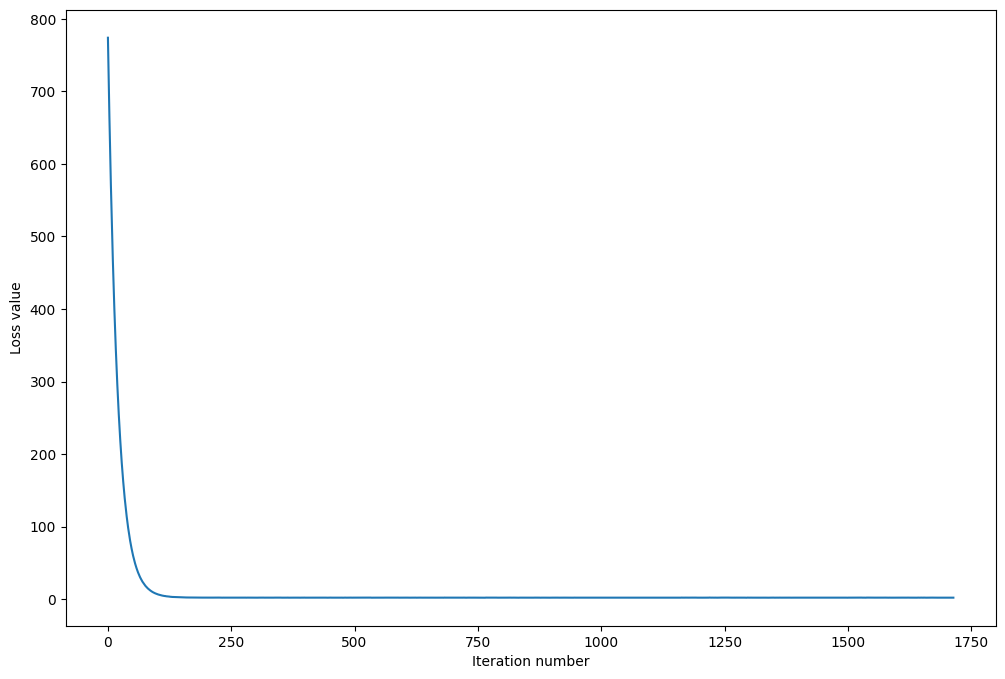

In [11]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### 5.2 Quantitative Analysis

Go back to the `LinearModel` implementation and complete the definition of the `predict()` function. Recreate and retrain the model (as the class definition has been updated) -- i.e. run Section 4 again. Then, we can analyze the accuracy of the predictions as follows. You should see around 32\%-33\% accuracies.

In [12]:
y_train_pred = model.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))

y_val_pred = model.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.321653
validation accuracy: 0.344000


### 5.3 Visual Results

Let us look at some visual results. You should see that many of the predictions are off, as we should expect from low accuracy values. This is expected since a linear model is limited for such a classification problem.

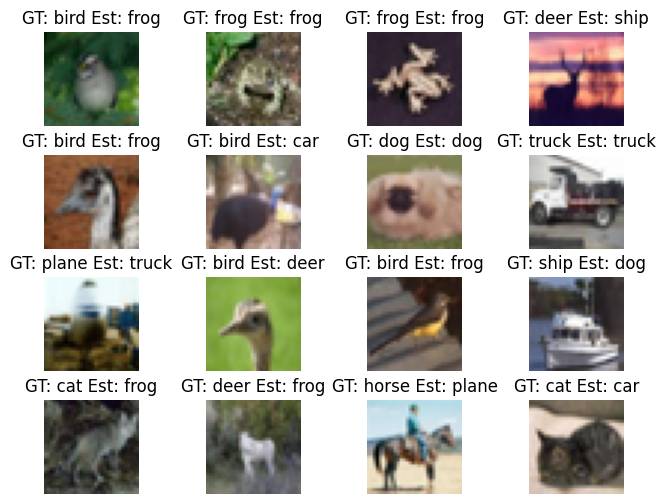

In [13]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

S = 4 # SxS random samples will be selected and drawn

plt.rcParams['figure.figsize'] = [8, 6]

for i in range(S):
  for j in range(S):
    id = np.random.randint(y_test.shape[0])
    X = X_test[id]
    y = y_test[id]
    plt.subplot(S, S, i*S+j+1)
    plt.imshow((X[:-1]+mean_image).reshape(32,32,3).astype('uint8'))
    pred = model.predict(X.reshape(1, 3073))
    plt.axis('off')
    plt.title("GT: " + classes[y] + " Est: " + classes[pred[0]])
    plt.subplots_adjust(hspace = 0.3)

plt.show()
plt.rcParams['figure.figsize'] = [6, 4]

### 5.4 Visualize Weights

Let us visualize the weights for each class. You should see images that look like templates for each class.

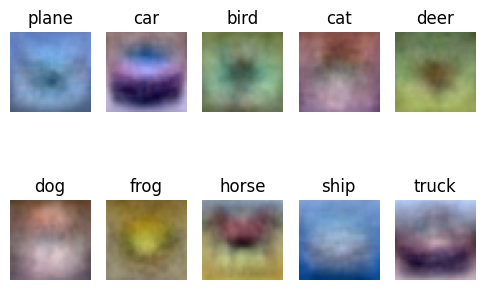

In [14]:
w = model.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

## 6 Tune your Model

Like we did in Task 1, tune the hyperparameters for a range of learning rates and regularization strengths. You should be able to obtain ~39\% accuracies with tuning. You can directly copy-paste this part from Task 1.

In [15]:
learning_rates = [1e-7, 1e-6, 1e-5]
regularization_strengths = [1e3, 2e3, 3e3, 1e4, 2e4, 3e4, 1e5, 2e3, 3e5]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearLayer object that achieved the highest validation rate.
best_lr = None  # The learning rate for the best model
best_rg = None  # The regularization strength for the best model

for lr in learning_rates:
  for rg in regularization_strengths:
    ############################################################################
    # @TODO: Write your code below in the parts marked with @TODO              #
    ############################################################################
    
    ## @TODO: Create a new SVM instance
    num_of_classes = np.max(y_test) + 1 # assume y takes values 0...K-1 where K is number of classes
    num_of_samples, num_of_dim = X_train.shape
    model = SoftmaxLayer(num_of_dim, num_of_classes)

    
    ## @TODO: Create a new loss instance with current rg and margin=1
    loss_fn = NLL_Loss(reg=rg)
    
    ## @TODO: Train with the training set with current lr and rg for 3 epochs   
    train(model, loss_fn, X_train, y_train, learning_rate=lr, epochs=3, batch_size=200, verbose=True)
    
    # @TODO: Predict values for training set and the validation set
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    
    ############################################################################
    #                              END OF YOUR CODE                            #
    ############################################################################
    
    # Calculate training and validation accuracies
    train_accuracy = np.mean(y_train_pred == y_train)
    val_accuracy = np.mean(y_val_pred == y_val)

    print(f"learning rate={lr} and regularization={rg:E} provided train_accuracy={train_accuracy:.3f} and val_accuracy={val_accuracy:.3f}")
    
    # Save the results
    results[(lr,rg)] = (train_accuracy, val_accuracy)
    if best_val < val_accuracy:
        best_lr = lr
        best_rg = rg
        best_val = val_accuracy
        best_model = model
    
print(f'\nbest validation accuracy achieved during cross-validation: {best_val} with params reg={best_rg} and lr={best_lr}')

Epoch 0 / 3: 17.763325163870405
Epoch 1 / 3: 16.968189910454154
Epoch 2 / 3: 15.853218183102934
learning rate=1e-07 and regularization=1.000000E+03 provided train_accuracy=0.217 and val_accuracy=0.239
Epoch 0 / 3: 30.911778659279552
Epoch 1 / 3: 28.136545674867577
Epoch 2 / 3: 25.302951870492997
learning rate=1e-07 and regularization=2.000000E+03 provided train_accuracy=0.220 and val_accuracy=0.242
Epoch 0 / 3: 42.770740282881405
Epoch 1 / 3: 37.090747072238344
Epoch 2 / 3: 31.908203512490267
learning rate=1e-07 and regularization=3.000000E+03 provided train_accuracy=0.223 and val_accuracy=0.246
Epoch 0 / 3: 96.77912373348322
Epoch 1 / 3: 59.850495505457275
Epoch 2 / 3: 37.15797385513866
learning rate=1e-07 and regularization=1.000000E+04 provided train_accuracy=0.253 and val_accuracy=0.277
Epoch 0 / 3: 117.78587746913651
Epoch 1 / 3: 45.26962245064604
Epoch 2 / 3: 18.109606781367255
learning rate=1e-07 and regularization=2.000000E+04 provided train_accuracy=0.294 and val_accuracy=0.32

<ipython-input-7-d453904d6c72>:25: RuntimeWarning: divide by zero encountered in log
  loss = (np.sum(-np.log(probs[np.arange(N),y])) / N )  + np.sum(W**2 * reg/2)


Epoch 0 / 3: inf
Epoch 1 / 3: inf


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-7-d453904d6c72>:25: RuntimeWarning: overflow encountered in multiply
  loss = (np.sum(-np.log(probs[np.arange(N),y])) / N )  + np.sum(W**2 * reg/2)
<ipython-input-7-d453904d6c72>:25: RuntimeWarning: overflow encountered in square
  loss = (np.sum(-np.log(probs[np.arange(N),y])) / N )  + np.sum(W**2 * reg/2)


Epoch 2 / 3: inf
learning rate=1e-05 and regularization=3.000000E+05 provided train_accuracy=0.076 and val_accuracy=0.090

best validation accuracy achieved during cross-validation: 0.389 with params reg=3000.0 and lr=1e-06


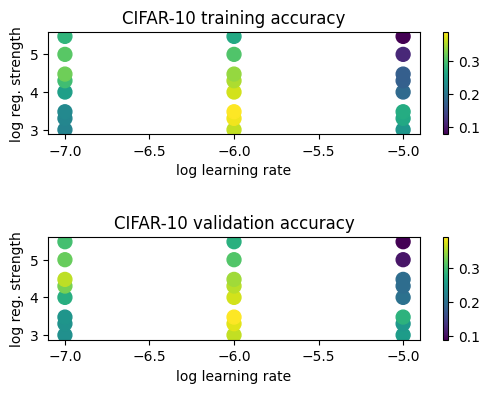

In [16]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log reg. strength')
plt.title('CIFAR-10 training accuracy')
plt.subplots_adjust(hspace = 1)

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log reg. strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [17]:
# Train the best model longer
best_model = SoftmaxLayer(num_of_dim, num_of_classes)
loss_fn = NLL_Loss(reg=best_rg)
loss_history = train(best_model, loss_fn, X_train, y_train, learning_rate=best_lr, epochs=5, batch_size=200, verbose=True)

Epoch 0 / 5: 12.430516267917884
Epoch 1 / 5: 4.297636133418944
Epoch 2 / 5: 2.373937208953451
Epoch 3 / 5: 1.99589461621136
Epoch 4 / 5: 1.9086982469896494


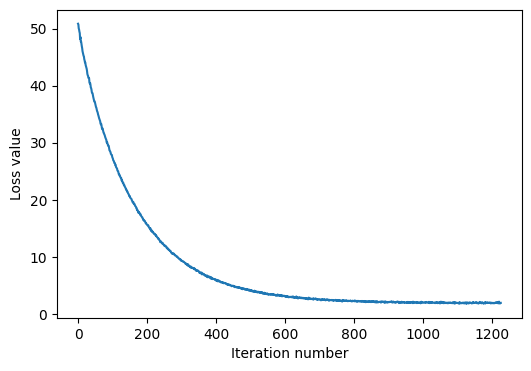

In [18]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [19]:
y_train_pred = best_model.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))

y_val_pred = best_model.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.396082
validation accuracy: 0.393000
